# Data visualization and EDA for CryoET project

Adapted some code from these notebooks:
* https://www.kaggle.com/code/davidlist/full-catalog-of-labeled-particles
* https://www.kaggle.com/code/rmsbms/eda-particles-visualization

In [4]:
!pip install zarr
!pip install -q ome-zarr
!pip install -q copick

In [41]:
#IMPORTS
import json
import numpy as np
import zarr
import random
import os

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio

pio.renderers.default = 'iframe'

In [10]:
#CONSTANTS
TRAIN_BASE = '/kaggle/input/czii-cryo-et-object-identification/train/static/ExperimentRuns'
TEST_BASE = '/kaggle/input/czii-cryo-et-object-identification/test/static/ExperimentRuns'
OVERLAY_BASE = '/kaggle/input/czii-cryo-et-object-identification/train/overlay/ExperimentRuns'
TRAINING_SETS = ['TS_86_3', 'TS_6_6', 'TS_73_6', 'TS_99_9', 'TS_69_2', 'TS_6_4', 'TS_5_4']
PARTICLE_RADIUS = {
    'apo-ferritin': 60.0,
    'beta-amylase': 65.0,
    'beta-galactosidase': 90.0,
    'ribosome': 150.0,
    'thyroglobulin': 130.0,
    'virus-like-particle': 135.0,
}

In [11]:
#FUNCTIONS
def get_experiment_path(experiment, type='denoised', test=False):
    base = TEST_BASE if test else TRAIN_BASE
    return base + '/' + experiment + '/VoxelSpacing10.000/' + type + '.zarr'

def open_experiment(experiment, test=False):
    return zarr.open(get_experiment_path(experiment, test=test), mode='r')

def load_points(experiment, particle='ribosome'):
    results = []
    path = OVERLAY_BASE + '/' + experiment + '/Picks/' + particle + '.json'
    with open(path) as f:
        points = json.loads(f.read())['points']
        for p in points:
            x = float(p['location']['x'])
            y = float(p['location']['y'])
            z = float(p['location']['z'])
            results.append((x, y, z))
    return results

def normalize(dataset):
    return (dataset - np.mean(dataset))/np.std(dataset)

# Example loading and processing data

In [185]:
#define path to zarr file of interest
zarr_path = os.path.join(TRAIN_BASE,'TS_5_4/VoxelSpacing10.000/wbp.zarr')

# Open the zarr array
zarr_store = zarr.open(str(zarr_path))

#0, 1, and 2 represent different resolutions of the same underlying data
print(zarr_store.tree())

/
 ├── 0 (184, 630, 630) float32
 ├── 1 (92, 315, 315) float32
 └── 2 (46, 158, 158) float32


In [186]:
# Get the highest resolution data (scale 0)
my_tomogram = zarr_store['0'][:]

print(f"Tomogram shape: {my_tomogram.shape}")
print(f"Min value: {my_tomogram.min()}")
print(f"Max value: {my_tomogram.max()}")
print(f"Mean value: {my_tomogram.mean()}")

Tomogram shape: (184, 630, 630)
Min value: -0.0010549420258030295
Max value: 0.0009750329190865159
Mean value: 2.514233301553759e-07


In [187]:
#explore the JSON file structure for an example protein
json_path = os.path.join(OVERLAY_BASE,'TS_5_4/Picks/apo-ferritin.json')

with open(json_path, 'r') as f:
    my_data = json.load(f)

#keys:
my_data.keys()

dict_keys(['pickable_object_name', 'user_id', 'session_id', 'run_name', 'voxel_spacing', 'unit', 'points', 'trust_orientation'])

In [188]:
#look at some entries in "points" - I believe these represent annotated apo-ferritin locations
my_data['points'][:3]

[{'location': {'x': 468.514, 'y': 5915.906, 'z': 604.167},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0},
 {'location': {'x': 5674.694, 'y': 1114.354, 'z': 565.068},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0},
 {'location': {'x': 5744.509, 'y': 1049.172, 'z': 653.712},
  'transformation_': [[1.0, 0.0, 0.0, 0.0],
   [0.0, 1.0, 0.0, 0.0],
   [0.0, 0.0, 1.0, 0.0],
   [0.0, 0.0, 0.0, 1.0]],
  'instance_id': 0}]

In [189]:
#extract and format the coordinates from "points"
def format_coords(data):
    coords = []
    for point in data['points']:
        coords.append([
            point['location']['z'],
            point['location']['y'],
            point['location']['x']
        ])
    
    coords = np.array(coords)
    return(coords)

af_coords = format_coords(my_data)
len(af_coords)

46

In [190]:
# Print some basic statistics
print("\nCoordinate ranges:")
print(f"Z range: {af_coords[:, 0].min():.1f} to {af_coords[:, 0].max():.1f}")
print(f"Y range: {af_coords[:, 1].min():.1f} to {af_coords[:, 1].max():.1f}")
print(f"X range: {af_coords[:, 2].min():.1f} to {af_coords[:, 2].max():.1f}")


Coordinate ranges:
Z range: 76.3 to 1296.6
Y range: 1049.2 to 5915.9
X range: 468.5 to 5880.8


In [191]:
#coordinates should be scaled prior to plotting
def scale_coordinates(coords, tomogram_shape):
    """Scale coordinates to match tomogram dimensions."""
    scaled_coords = coords.copy()
    
    # Scale factors for each dimension
    scale_z = tomogram_shape[0] / coords[:, 0].max()
    scale_y = tomogram_shape[1] / coords[:, 1].max()
    scale_x = tomogram_shape[2] / coords[:, 2].max()
    
    # Apply scaling
    scaled_coords[:, 0] = coords[:, 0] * scale_z
    scaled_coords[:, 1] = coords[:, 1] * scale_y
    scaled_coords[:, 2] = coords[:, 2] * scale_x
    
    return scaled_coords


scaled_af_coords = scale_coordinates(af_coords, my_tomogram.shape)

print("\nCoordinate ranges after scaling:")
print(f"Z range: {scaled_af_coords[:, 0].min():.1f} to {scaled_af_coords[:, 0].max():.1f}")
print(f"Y range: {scaled_af_coords[:, 1].min():.1f} to {scaled_af_coords[:, 1].max():.1f}")
print(f"X range: {scaled_af_coords[:, 2].min():.1f} to {scaled_af_coords[:, 2].max():.1f}")


Coordinate ranges after scaling:
Z range: 10.8 to 184.0
Y range: 111.7 to 630.0
X range: 50.2 to 630.0


# Visualizing particles in tomogram slices

## Visualizing one type of particle

In [198]:
def visualize_particles(
    tomogram, coords, particle='apo-ferritin', n_slices=3, slice_thickness=10,
    seed=1337, figsize=(20, 10), arrow_offset=5, arrow_alpha=0.5, z_positions_override=None,
) -> None:
    """
    Visualize particles in tomogram slices.
    """
    
    valid_particles = ['apo-ferritin','beta-amylase','beta-galactosidase','ribosome','thyroglobulin','virus-like-particle']
    assert particle in valid_particles, 'particle name misspelled'
    
    fig, ax = plt.subplots(figsize=figsize, ncols=n_slices)
    random.seed(seed)
    
    # # Normalize tomogram data
    # vmin, vmax = np.percentile(tomogram, (1, 99))
    # tomogram = np.clip((tomogram - vmin) / (vmax - vmin), 0, 1)
    
    # Calculate evenly spaced z-positions
    z_positions = sorted(random.sample(range(0, tomogram.shape[0]-1), n_slices))
    if z_positions_override is not None and len(z_positions_override)==n_slices:
        z_positions = z_positions_override
    
    # Plot each slice
    for z, my_ax in zip(z_positions,ax):
        # Show tomogram slice
        im = my_ax.imshow(normalized_tomogram[z, :, :], cmap='gray')
        
        # Find particles near this slice
        mask = np.abs(coords[:, 0] - z) < slice_thickness
        if np.any(mask):
            # my_ax.scatter(coords[mask, 2], coords[mask, 1],
            #               color='red', marker='o', s=100, 
            #               facecolors='none', linewidth=2,
            #               label=particle)
            # sns.scatterplot(x=coords[mask, 2], y=coords[mask, 1], ax=my_ax, color='red')
            for x, y in zip(coords[mask, 2],coords[mask, 1]):
                my_ax.annotate(text="", xy=(x-arrow_offset,y-arrow_offset), xytext=(x-30-arrow_offset,y-30-arrow_offset), size=16, ha="center",
                               arrowprops=dict(arrowstyle="->", lw=1, color='red', alpha=arrow_alpha)) #connectionstyle="angle3"
        
        my_ax.set_title(f'Slice Z={z}\n({np.sum(mask)} particles visible)')
        
        # Set the axes limits to match the tomogram dimensions
        my_ax.set_xlim(0, tomogram.shape[2])
        my_ax.set_ylim(tomogram.shape[1], 0)  # Inverted y-axis to match image coordinates
    
    fig.suptitle(f'{particle} particles in tomogram slices\n' + 
                 f'Showing particles within ±{slice_thickness} units of each slice',
                 fontsize=16, y=0.83)

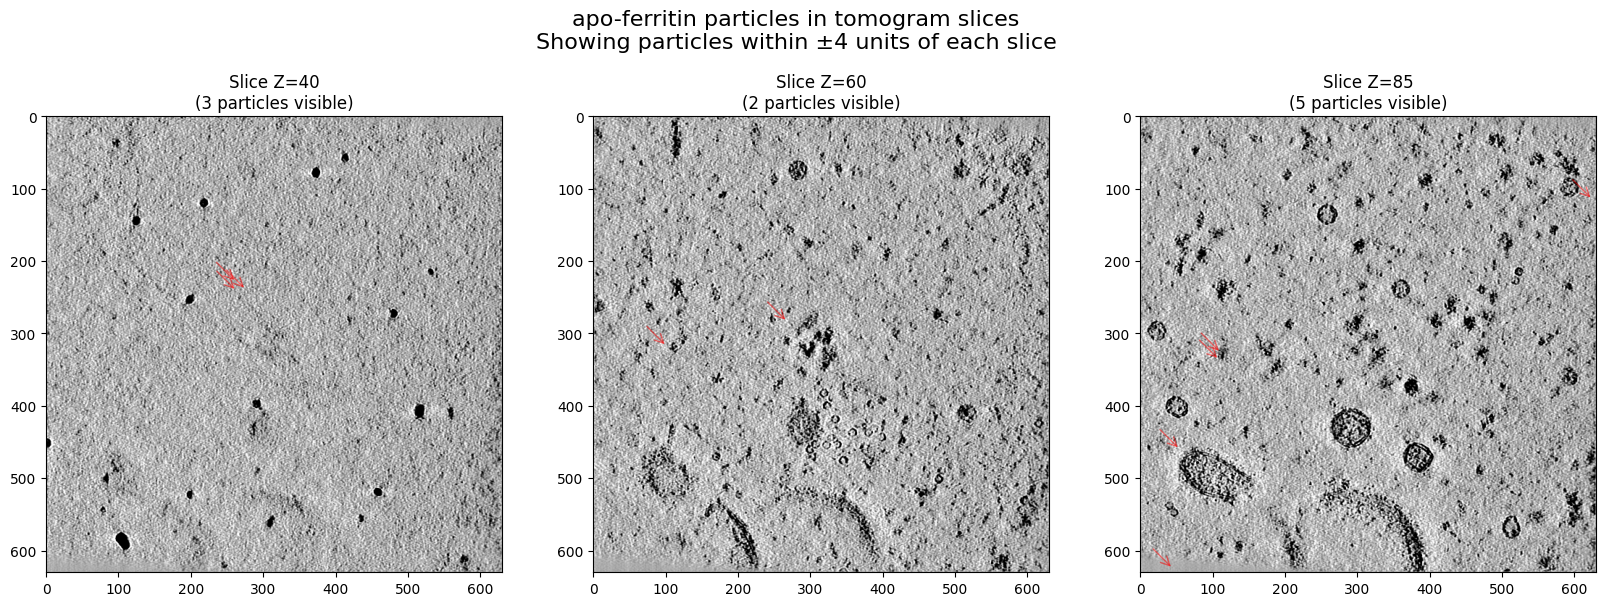

In [202]:
visualize_particles(
    tomogram = my_tomogram,
    coords = scaled_af_coords,
    particle='apo-ferritin',
    n_slices=3,
    slice_thickness=4,
    figsize=(20, 10),
    arrow_offset=5,
    arrow_alpha=0.5,
    z_positions_override=[40, 60, 85],
)

In [200]:
with open(os.path.join(OVERLAY_BASE,'TS_5_4/Picks/virus-like-particle.json'), 'r') as f:
    vlp_data = json.load(f)
vlp_coords = format_coords(vlp_data)
scaled_vlp_coords = scale_coordinates(vlp_coords, my_tomogram.shape)

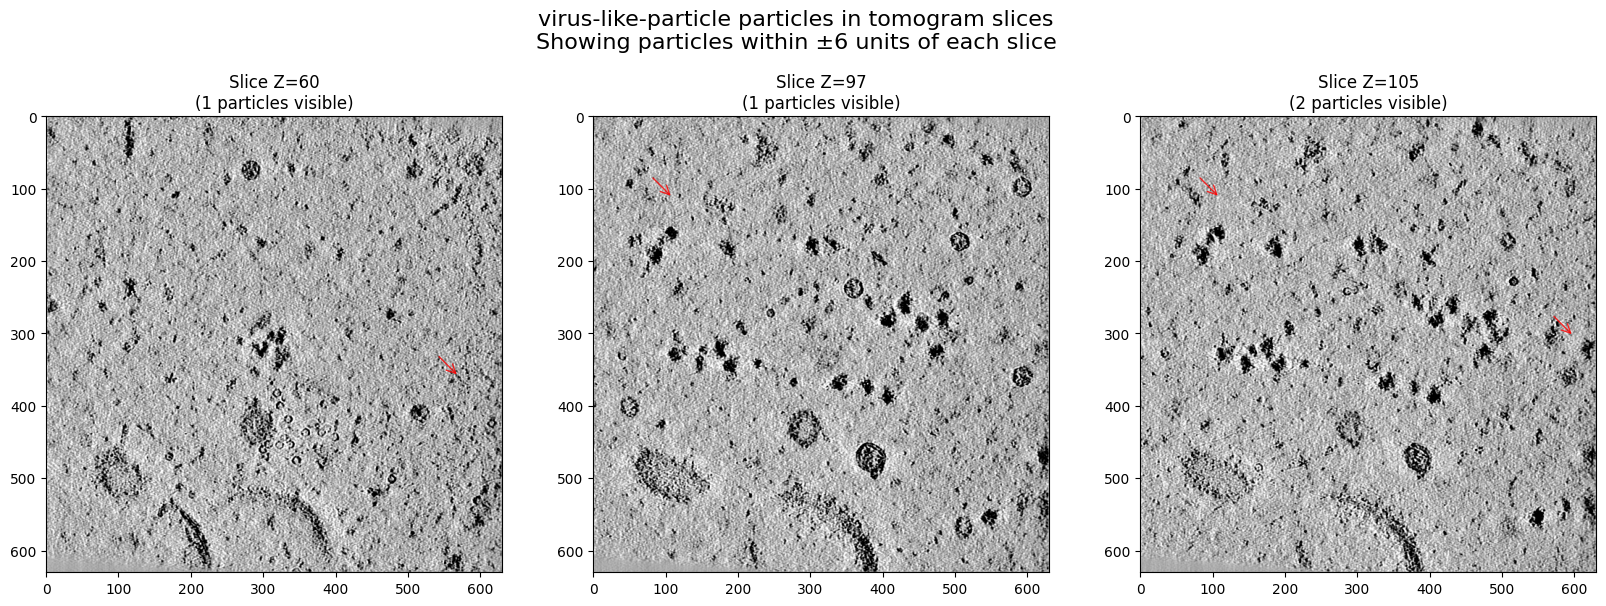

In [201]:
visualize_particles(
    tomogram = my_tomogram,
    coords = scaled_vlp_coords,
    particle='virus-like-particle',
    n_slices=3,
    slice_thickness=6,
    figsize=(20, 10),
    arrow_offset=5,
    arrow_alpha=0.8,
    z_positions_override=[60, 97, 105],
)

# Plot example tomogram sections for each particle

In [196]:
def plot_particles(experiment, particle, n_show=9, seed=1337):
    random.seed(seed)
    
    dataset = normalize(open_experiment(experiment)[0])
    particles = load_points(experiment, particle=particle)
    p_subset = sorted(random.sample(particles,n_show), key=lambda p: p[2])
    
    plt.figure(figsize=(10, 3.5*(len(p_subset)//3 + 1)))
    for idx in range(len(p_subset)):
        i = int(np.rint(p_subset[idx][0]/10.012))
        j = int(np.rint(p_subset[idx][1]/10.012))
        k = int(np.rint(p_subset[idx][2]/10.012))

        # Fix display problem near the edges.
        i_min = i - 24 if i - 24 > 0 else 0
        j_min = j - 24 if j - 24 > 0 else 0
        
        plt.subplot(len(p_subset)//3 + 1, 3, idx + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(str(idx) + ': ' + str((k,j,i,)))
        plt.imshow(dataset[k, (j_min):(j+25), (i_min):(i+25)], cmap='gray')

## Apo-Ferritin

![](https://www.ebi.ac.uk/pdbe/emdb-empiar/entryIcons//10263-l.gif)

Image from the following source:  
[https://www.ebi.ac.uk/empiar/EMPIAR-10263/](https://www.ebi.ac.uk/empiar/EMPIAR-10263/)  
This is the actual particle for the competition:  
[https://www.rcsb.org/structure/4V1W](https://www.rcsb.org/structure/4V1W)

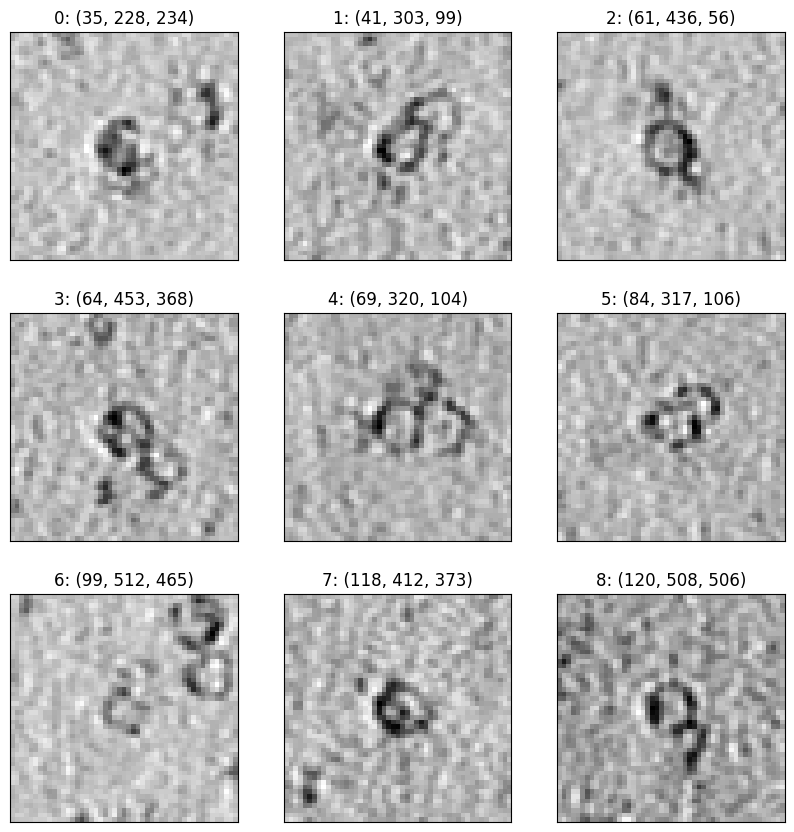

In [197]:
plot_particles('TS_5_4', 'apo-ferritin',n_show=9)

## Beta-Amylase

![](https://cdn.rcsb.org/images/structures/1fa2_assembly-1.jpeg)  

Image from the following source:  
[https://www.rcsb.org/structure/1fa2](https://www.rcsb.org/structure/1fa2)

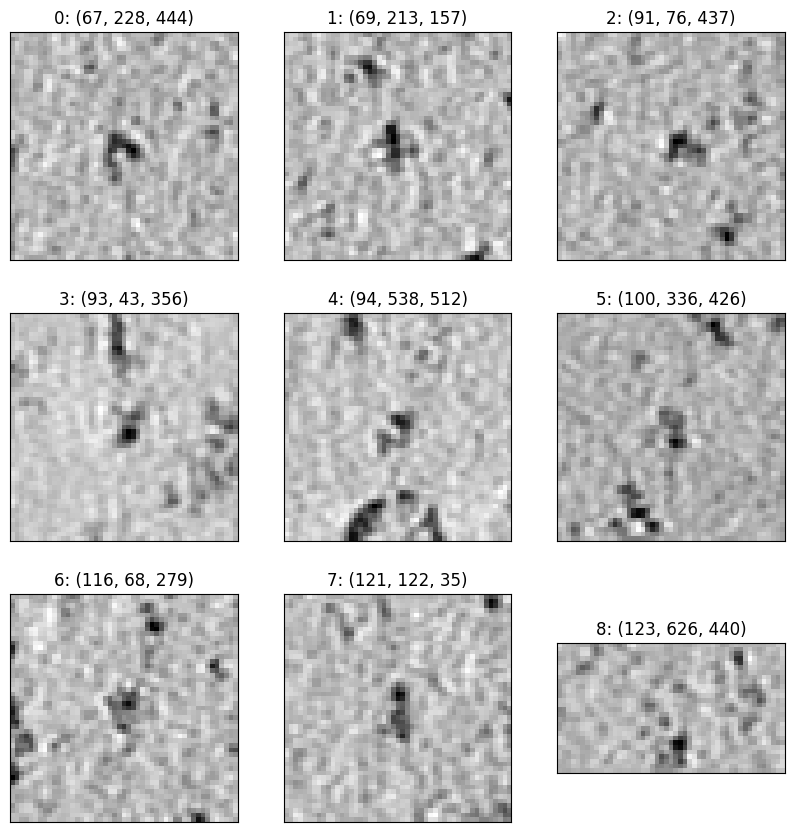

In [66]:
plot_particles('TS_69_2', 'beta-amylase',n_show=9)

## Beta-Galactosidase

![](https://cdn.rcsb.org/images/structures/6x1q_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6X1Q](https://www.rcsb.org/structure/6X1Q)

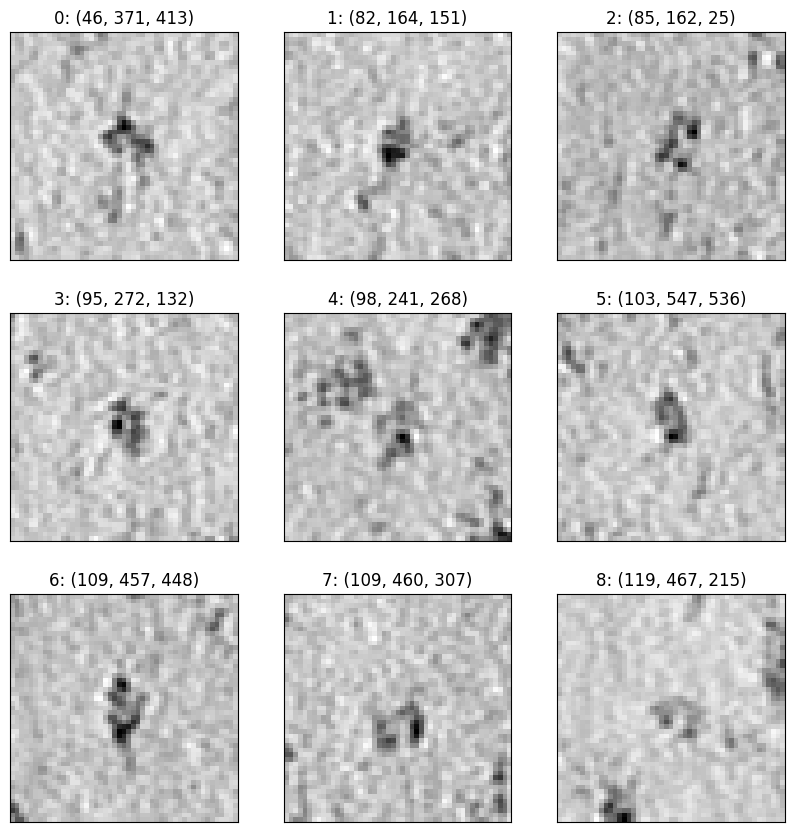

In [67]:
plot_particles('TS_6_4', 'beta-galactosidase',n_show=9)

## Ribosome

![](https://cdn.rcsb.org/images/structures/6qzp_assembly-1.jpeg)  

Image from this source:  
[https://www.rcsb.org/structure/6QZP](https://www.rcsb.org/structure/6QZP) 

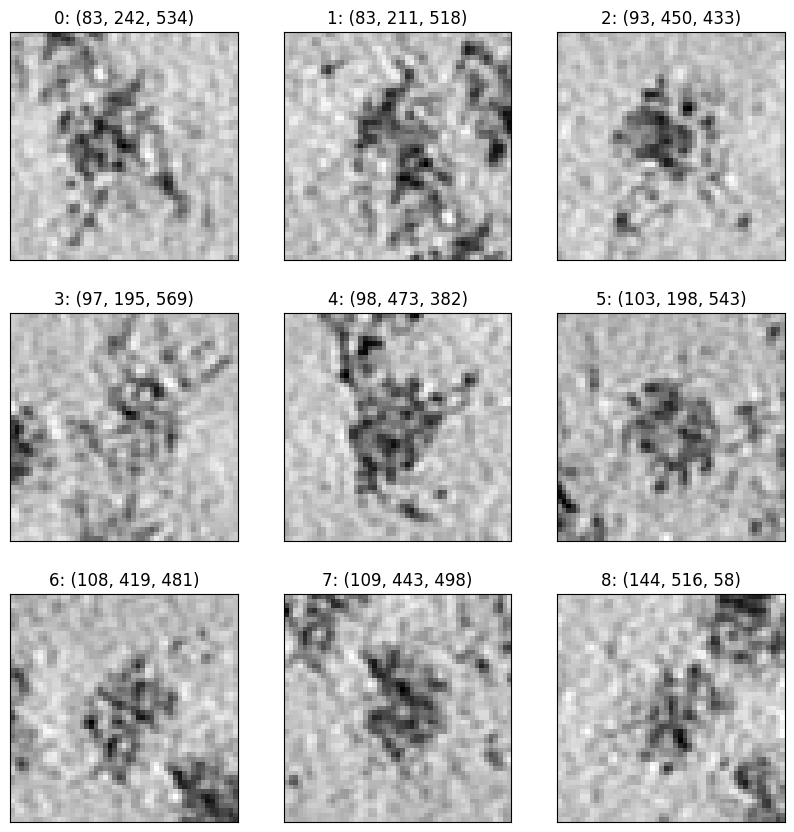

In [68]:
plot_particles('TS_6_6', 'ribosome',n_show=9)

## Thyroglobulin

![](https://cdn.rcsb.org/images/structures/6scj_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6scj](https://www.rcsb.org/structure/6scj)

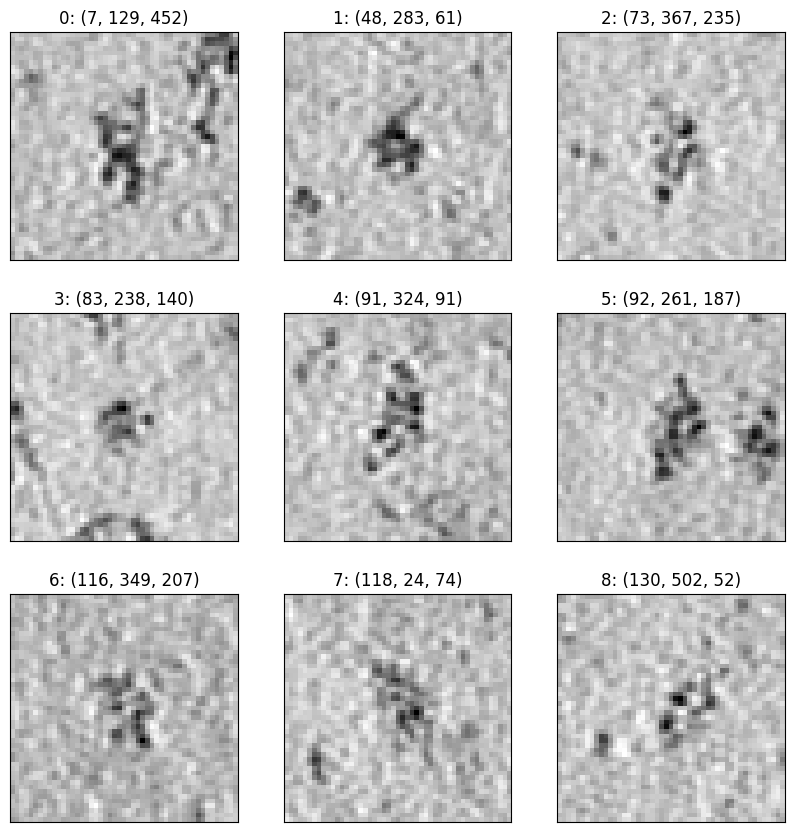

In [69]:
plot_particles('TS_73_6', 'thyroglobulin',n_show=9)

## Virus-Like-Particle

![](https://cdn.rcsb.org/images/structures/6n4v_assembly-1.jpeg)

Image from this source:  
[https://www.rcsb.org/structure/6N4V](https://www.rcsb.org/structure/6N4V)

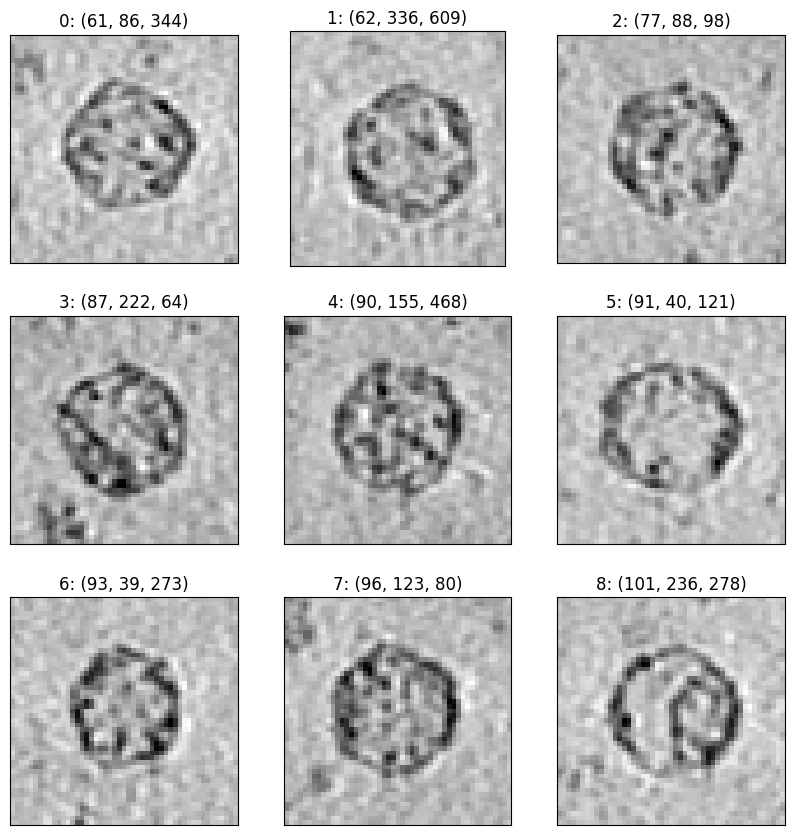

In [70]:
plot_particles('TS_86_3', 'virus-like-particle',n_show=9)

# Plot 3D position map for each particle, using an arbitrary experiment

In [39]:
def plot_particles_3d(experiment, particles_to_plot):
    if isinstance(particles_to_plot,str):
        particles_to_plot = [particles_to_plot]
        
    particle_list = []
    for particle in particles_to_plot:
        particle_coords = load_points(experiment, particle=particle)
        for p in particle_coords:
            particle_list.append({'pname':particle, 'x':np.rint(p[0]/10.012),
                                  'y':np.rint(p[1]/10.012), 'z':np.rint(p[2]/10.012), 'size': 1})
        
    fig = px.scatter_3d(particle_list, x='x', y='y', z='z', color='pname', size='size',
                        range_x=[630,0], range_y=[0,630], range_z=[184,0],
                        title=experiment + ': ' + particle,
                        template='seaborn')
    fig.show()

In [42]:
plot_particles_3d('TS_5_4', ['apo-ferritin','beta-amylase','beta-galactosidase','ribosome','thyroglobulin','virus-like-particle'])